In [ ]:
# library dependencies
!pip install transformers[torch]

In [3]:
# data dependencies
!wget -O consumer_complaints.csv https://s3.amazonaws.com/kaggle.live/complaints/consumer_complaints.csv
!wget -O common.py https://s3.amazonaws.com/kaggle.live/helper/common.py

--2020-09-23 12:00:56--  https://s3.amazonaws.com/kaggle.live/complaints/consumer_complaints.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.113.181
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.113.181|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 175385569 (167M) [text/csv]
Saving to: 'consumer_complaints.csv'

     0K .......... .......... .......... .......... ..........  0% 1.27M 2m12s
    50K .......... .......... .......... .......... ..........  0% 2.66M 97s
   100K .......... .......... .......... .......... ..........  0% 12.1M 69s
   150K .......... .......... .......... .......... ..........  0% 3.24M 65s
   200K .......... .......... .......... .......... ..........  0% 12.3M 55s
   250K .......... .......... .......... .......... ..........  0% 14.9M 47s
   300K .......... .......... .......... .......... ..........  0% 3.26M 48s
   350K .......... .......... .......... .......... ..........  0% 19.9M 43s
   400K ........

 49650K .......... .......... .......... .......... .......... 29% 14.3M 10s
 49700K .......... .......... .......... .......... .......... 29% 17.3M 10s
 49750K .......... .......... .......... .......... .......... 29% 14.0M 10s
 49800K .......... .......... .......... .......... .......... 29% 7.24M 10s
 49850K .......... .......... .......... .......... .......... 29% 10.9M 10s
 49900K .......... .......... .......... .......... .......... 29% 17.3M 10s
 49950K .......... .......... .......... .......... .......... 29% 15.5M 10s
 50000K .......... .......... .......... .......... .......... 29% 12.2M 10s
 50050K .......... .......... .......... .......... .......... 29% 7.10M 10s
 50100K .......... .......... .......... .......... .......... 29% 16.3M 10s
 50150K .......... .......... .......... .......... .......... 29% 15.9M 10s
 50200K .......... .......... .......... .......... .......... 29% 11.5M 10s
 50250K .......... .......... .......... .......... .......... 29% 13.3M 10s

--2020-09-23 12:01:10--  https://s3.amazonaws.com/kaggle.live/helper/common.py
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.171.5
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.171.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3764 (3.7K) [text/plain]
Saving to: 'common.py'

     0K ...                                                   100% 6.42M=0.001s

2020-09-23 12:01:10 (6.42 MB/s) - 'common.py' saved [3764/3764]



In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import multiprocessing
from transformers import AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import StratifiedKFold
from tqdm.notebook import tqdm
from common import Common, Timer

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import random

pd.set_option('display.max_colwidth', -1)

C:\Users\bill\software\anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [3]:
data = pd.read_csv('consumer_complaints.csv', low_memory=False)
data = data[~data['consumer_complaint_narrative'].isna()].reset_index()
data = data[['product', 'consumer_complaint_narrative']].rename(columns={
    'consumer_complaint_narrative': 'complaints'
})

products = sorted(list(data['product'].unique()))
data['product_id'] = data['product'].apply(lambda x : products.index(x))

In [4]:
data.head(n=2)

,product,complaints,product_id
0,Debt collection,XXXX has claimed I owe them {$27.00} for XXXX years despite the PROOF of PAYMENT I sent them : canceled check and their ownPAID INVOICE for {$27.00}! \nThey continue to insist I owe them and collection agencies are after me. \nHow can I stop this harassment for a bill I already paid four years ago? \n,4
1,Consumer Loan,"Due to inconsistencies in the amount owed that I was told by M & T Bank and the amount that was reported to the credit reporting agencies, I was advised to write a good will letter in order to address the issue and request the negative entry be removed from my credit report all together. I had a vehicle that was stolen and it was declared a total loss by insurance company. The insurance company and the GAP insurancw companypaid the outstanding balance of the loan, but I was told by M & T Bank that there was still a balance due on the loan. In good faith, without having received any proof as to why there was still a balance, I made a partial payment towards the remaining debt. I then sent the goodwill letter still offering to pay the remainder of the debt, but in exchange for the removal of the negative entry on my credit report. At one point, in XXXX 2015, per my credit monitoring agency, it showed a delinquent balance of {$0.00}, but when I checked my credit report again on XXXX XXXX 2015, there was a delinquent balance of {$1400.00}. The monies from the GAP insurance and my insurance company has been paid, M & T Bank says that I still owe {$620.00}, of which {$210.00} has already been paid. I contacted M & T Bank via return receipt mail, but I have not been given the courtesy of a response yet. \n",1


Debt collection            26.27
Mortgage                   22.33
Credit reporting           18.75
Credit card                11.87
Bank account or service    8.55 
Consumer Loan              5.51 
Student loan               3.19 
Prepaid card               1.29 
Payday loan                1.09 
Money transfers            1.00 
Other financial service    0.16 
Name: product, dtype: float64


C:\Users\bill\software\anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


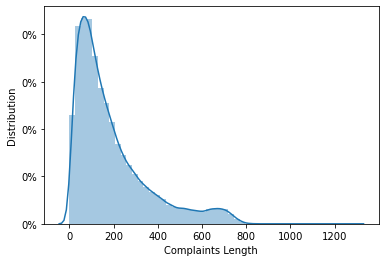

In [5]:
# print product distribution
def print_prod_dist(x):
    print(round(x['product'].value_counts() / x.shape[0] * 100, 2))

print_prod_dist(data)

# show complaint length distribution
x = data['complaints']
ax = sns.distplot(x.str.split().apply(len))
ax.set(xlabel='Complaints Length', ylabel='Distribution')
ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])
plt.show()

In [6]:
MAX_WORKERS = multiprocessing.cpu_count() - 1
B = 8
E = 5
T = 800
Y = len(data['product'].unique())

# truncate complaints
data['complaints'] = data['complaints'].apply(lambda x : x[:T])

In [7]:
# doing k-folds to generate training, validation, and test datasets
np.random.seed(0)

skf1 = StratifiedKFold(n_splits=10)
skf2 = StratifiedKFold(n_splits=10)
dfs = []
for i, j in skf1.split(list(data['complaints']), list(data['product_id'])):
    data_df = data.iloc[i].copy().reset_index(drop=True)
    test_df = data.iloc[j].copy().reset_index(drop=True)
    for i, j in skf2.split(list(data_df['complaints']), list(data_df['product_id'])):
        train_df = data_df.iloc[i].copy().reset_index(drop=True)
        valid_df = data_df.iloc[j].copy().reset_index(drop=True)
        break
    dfs.append([ train_df, valid_df, test_df ])

train_df, valid_df, test_df = dfs[0]
print('## Training Dataset: {}'.format(train_df.shape[0]))
print_prod_dist(train_df)

print('\n## Validation Dataset: {}'.format(valid_df.shape[0]))
print_prod_dist(valid_df)

print('\n## Test Dataset: {}'.format(test_df.shape[0]))
print_prod_dist(test_df)

## Training Dataset: 54112
Debt collection            26.27
Mortgage                   22.33
Credit reporting           18.75
Credit card                11.87
Bank account or service    8.55 
Consumer Loan              5.51 
Student loan               3.18 
Prepaid card               1.29 
Payday loan                1.09 
Money transfers            1.00 
Other financial service    0.16 
Name: product, dtype: float64

## Validation Dataset: 6013
Debt collection            26.28
Mortgage                   22.33
Credit reporting           18.74
Credit card                11.86
Bank account or service    8.55 
Consumer Loan              5.50 
Student loan               3.19 
Prepaid card               1.30 
Payday loan                1.08 
Money transfers            1.00 
Other financial service    0.17 
Name: product, dtype: float64

## Test Dataset: 6681
Debt collection            26.28
Mortgage                   22.33
Credit reporting           18.75
Credit card                11.87
Ban

In [8]:
class Model(nn.Module):
    
    #model = 'distilbert-base-cased'
    def __init__(self, model, T, Y, device):
        super(Model, self).__init__()
        self.T = T
        self.device = device
        self.tokenizer = AutoTokenizer.from_pretrained(model, do_lower_case=True)
        self.model = AutoModel.from_pretrained(model)
        # move the first three layers
        #for _ in range(4):
        #    self.model.transformer.layer.__delitem__(0)
        self.linear = nn.Linear(768, Y)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, inputs):
        tokens = self.tokenizer.batch_encode_plus(
            inputs, 
            add_special_tokens=True, 
            return_tensors='pt', 
            padding=True
        )['input_ids'].to(self.device)
        output = self.model(tokens)[0][:,0,:]
        output = self.dropout(output)
        output = self.linear(output)
        return output
    
def scoring(device, model, criterion, iterator):
    yhats = []
    with torch.no_grad():
        total_loss = []
        total_accy = []
        for x, y, _ in iterator:
            scores = model(x)
            loss = criterion(scores, y.to(device).long())
            total_loss.append(loss.item())
            total_accy.append(Common.accuracy(scores, y, device))
            for i in np.argmax(scores.detach().cpu().numpy(), axis=1):
                yhats.append(i)
    return np.mean(total_loss), np.mean(total_accy), yhats

np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [9]:
lr = 2e-5 #[2e-5, 3e-5, 4e-5, 5e-5]:

device = Common.device()
predict_df = []

k = 0
train_df, valid_df, test_df = dfs[0]

itrain = Common.generator(X=train_df['complaints'], Y=train_df['product_id'], batch_size=B, shuffle=True)
ivalid = Common.generator(X=valid_df['complaints'], Y=valid_df['product_id'], batch_size=B, shuffle=True)
itest = Common.generator(X=test_df['complaints'], Y=test_df['product_id'], batch_size=B, shuffle=False)

# 
model = Model('distilbert-base-uncased', T, Y, device).to(device)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('num of params: {}'.format(num_params))

optimizer = AdamW(model.parameters(),
    lr = lr, 
    eps = 1e-8, 
    weight_decay = 0.01
)

criterion = Common.criterion()

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps = 1, # Default value in run_glue.py
    num_training_steps = len(itrain) * E)

seed_val = 0

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

best_loss = 999
best_model = None
best_epoch = 0

for epoch in range(E):
    t = Timer()
    total_loss = []
    total_accy = []
    for x, y, _ in tqdm(itrain):

        # step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # step 3. Run our forward pass.
        scores = model(x)

        # step 4. Compute the loss, gradients, and update the parameters by
        loss = criterion(scores, y.to(device).long())
        total_loss.append(loss.item())
        total_accy.append(Common.accuracy(scores, y, device))

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    train_loss, train_accy = np.mean(total_loss), np.mean(total_accy)
    valid_loss, valid_accy, _ = scoring(device, model, criterion, ivalid)

    if valid_loss < best_loss:
        Common.save_checkpoint({
            'loss': valid_loss,
            'accuracy': valid_accy,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }, './models/model_{}.tar'.format(k))
        best_model = model
        best_epoch = epoch
        best_loss = valid_loss

    print(', '.join([
        'epoch: {}'.format(epoch),
        'train_loss: {:3.2}'.format(train_loss),
        'valid_loss: {:3.2}'.format(valid_loss),
        'train_accy: {:3.2%}'.format(train_accy),
        'valid_accy: {:3.2%}'.format(valid_accy),
        'time: {}'.format(t.get())
    ]))

test_loss, test_accy, test_yhats = scoring(device, best_model, criterion, itest)
print('test_loss: {:3.2}'.format(test_loss))
print('test_accy: {:3.2%}'.format(test_accy))

tmp = test_df.copy()
tmp['predicted_product'] = test_yhats
tmp['predicted_product'] = tmp['predicted_product'].apply(lambda x : products[x])
predict_df.append(tmp)

predict_df = pd.concat(predict_df, ignore_index=True)

num of params: 66371339


Token indices sequence length is longer than the specified maximum sequence length for this model (581 > 512). Running this sequence through the model will result in indexing errors


RuntimeError: CUDA out of memory. Tried to allocate 250.00 MiB (GPU 0; 8.00 GiB total capacity; 6.03 GiB already allocated; 108.04 MiB free; 6.11 GiB reserved in total by PyTorch)